Importing Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import json
import gc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sklearn import model_selection, preprocessing, metrics, linear_model
import lightgbm as lgb
from xgboost import XGBRegressor
%matplotlib inline
import plotly.graph_objects as go
import seaborn as sns
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


Using TensorFlow backend.


/kaggle/input/plotly_countries/2014_world_gdp_with_codes.csv
/kaggle/input/ga-customer-revenue-prediction/sample_submission_v2.csv
/kaggle/input/ga-customer-revenue-prediction/train_v2.csv
/kaggle/input/ga-customer-revenue-prediction/test_v2.csv
/kaggle/input/test-csv/test.csv
/kaggle/input/clean-csv/df_7_1.csv
/kaggle/input/clean-csv/df_7_2.csv


Cleaning the dataset

In [2]:
def clean_df(data_df):
    data_df.drop(columns=['customDimensions' ,'hits'], inplace=True)
    data_df['date'] = data_df['date'].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))
    data_df.drop(columns=['socialEngagementType'], inplace=True)
    data_df['browser'] = data_df['device'].apply(lambda x: json.loads(x)['browser'])
    data_df['operatingSystem'] = data_df['device'].apply(lambda x: json.loads(x)['operatingSystem'])
    data_df['deviceCategory'] = data_df['device'].apply(lambda x: json.loads(x)['deviceCategory'])
    data_df.drop(columns=['device'], inplace=True)
    data_df['continent'] = data_df['geoNetwork'].apply(lambda x: json.loads(x)['continent'])
    data_df['subContinent'] = data_df['geoNetwork'].apply(lambda x: json.loads(x)['subContinent'])
    data_df['country'] = data_df['geoNetwork'].apply(lambda x: json.loads(x)['country'])
    data_df['region'] = data_df['geoNetwork'].apply(lambda x: json.loads(x)['region'])
    data_df['city'] = data_df['geoNetwork'].apply(lambda x: json.loads(x)['city'])
    data_df['country'] = data_df['geoNetwork'].apply(lambda x: json.loads(x)['country'])
    data_df['region'] = data_df['geoNetwork'].apply(lambda x: json.loads(x)['region'])
    data_df['city'] = data_df['geoNetwork'].apply(lambda x: json.loads(x)['city'])
    data_df.drop(columns=['geoNetwork'], inplace=True)
    data_df['referralPath'] = pd.DataFrame(data_df['trafficSource'].apply(json.loads).tolist())['referralPath']
    data_df['source'] = pd.DataFrame(data_df['trafficSource'].apply(json.loads).tolist())['source']
    data_df['medium'] = pd.DataFrame(data_df['trafficSource'].apply(json.loads).tolist())['medium']
    data_df['visits'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['visits']
    data_df['hits'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['hits']
    data_df['pageviews'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['pageviews']
    data_df['timeonsite'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['timeOnSite']
    data_df['bounces'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['bounces']
    data_df['newVisits'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['newVisits']
    data_df['sessionQualityDim'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['sessionQualityDim']
    data_df['transactions'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['transactions']
    data_df['transactionRevenue'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['transactionRevenue']
    data_df['totalTransactionRevenue'] = pd.DataFrame(data_df['totals'].apply(json.loads).tolist())['totalTransactionRevenue']
    data_df.drop(columns=['totals'], inplace=True)
    data_df.drop(columns=['trafficSource'], inplace=True)
    return data_df

In [3]:
# conc_df = pd.DataFrame()
# for i in range(10, 21):
#     print('part '+ str(i) + ' .......loading........')
#     data = pd.read_csv('/kaggle/input/ga-customer-revenue-prediction/train_v2.csv',  nrows=70000)
#     if i > 0:
#         data = pd.read_csv('/kaggle/input/ga-customer-revenue-prediction/train_v2.csv',  nrows=70000 , header=None, skiprows= i*70000)
#         data.columns = ['channelGrouping', 'customDimensions', 'date', 'device',
#            'fullVisitorId', 'geoNetwork', 'hits', 'socialEngagementType', 'totals',
#            'trafficSource', 'visitId', 'visitNumber', 'visitStartTime']
#     clean_data = clean_df(data)
#     del data
#     gc.collect()
#     conc_df = pd.concat([conc_df, clean_data], axis=0)
#     print('part  '+ str(i)+ ' .........preprocessing done.... and memory occupied is......   ' + str(conc_df.memory_usage().sum()/(1024*1024)) + '  MB')
#     del clean_data
#     gc.collect()

In [4]:
#conc_df.to_csv('df_7_2.csv')

Loading Data and storing it in train_df.

In [5]:
train_1 = pd.read_csv('/kaggle/input/clean-csv/df_7_1.csv')
columns = train_1.columns
train_2 = pd.read_csv('/kaggle/input/clean-csv/df_7_2.csv')
train_2.columns = columns
train_df = pd.concat([train_1, train_2], axis=0)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [6]:
train_df['referralPath'].value_counts()

/                                                                                                                                                                118935
/yt/about/                                                                                                                                                        70610
/analytics/web/                                                                                                                                                   28416
/yt/about/tr/                                                                                                                                                     13238
/yt/about/vi/                                                                                                                                                     13055
                                                                                                                                                                

In [7]:
del train_1
del train_2
gc.collect()

33

In [8]:
df_country_codes = pd.read_csv('/kaggle/input/plotly_countries/2014_world_gdp_with_codes.csv')

In [9]:
train_df.drop(columns=['Unnamed: 0'], inplace=True)


In [10]:
test_df = pd.read_csv('/kaggle/input/test-csv/test.csv')

Filling NaN values with appropriate values for their respective columns i.e 0, mean and mode.

In [11]:
train_df = train_df[train_df['pageviews'].notnull()]
train_df['bounces'] = train_df['bounces'].fillna(0)
train_df['timeonsite'] = train_df['timeonsite'].fillna(3)
train_df['sessionQualityDim'] = train_df['sessionQualityDim'].fillna(train_df['sessionQualityDim'].mean())
train_df['newVisits'] = train_df['newVisits'].fillna(0)

In [12]:

train_df['session_id'] = train_df['visitId'].apply(str) + '_' + train_df['fullVisitorId'].apply(str) 
#Converting string(utc) to date format
train_df['visitStartTime'] = train_df['visitStartTime'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
train_df.drop(columns=['transactions','transactionRevenue'], inplace=True)
#Converting total transaction revenue to log for better representation of data.
train_df['log_revenue'] = np.log(train_df['totalTransactionRevenue'])
##Dropping referral path as there are too many categories:3001
train_df.drop(columns=['referralPath'], inplace=True)


In [13]:
transcations_done = train_df[train_df['totalTransactionRevenue'].notnull()]

In [14]:
#Taking the top 8 browsers and storing the rest as 'other'
v = train_df['browser'].value_counts().keys()[:8]
train_df['browser'] =  train_df['browser'].apply(lambda x: x if x in v else 'other')
#Taking the first 6 operating systems and marking remaining as 'other'
v = train_df['operatingSystem'].value_counts().keys()[:6]
train_df['operatingSystem'] =  train_df['operatingSystem'].apply(lambda x: x if x in v else 'other')
#Considering the 1000 values and storing rest as 'other'
source = list(train_df['source'].value_counts()[train_df['source'].value_counts()>1000].to_dict().keys())
train_df['source'] = train_df['source'].apply(lambda x: x if x in source else 'Other')

In [15]:
train_df['totalTransactionRevenue'] = train_df['totalTransactionRevenue'].astype(float)
train_df['fullVisitorId'] = train_df['fullVisitorId'].astype(str)
groupby_user_revenue = train_df.groupby(by = ['fullVisitorId'])['totalTransactionRevenue'].sum().reset_index()

From the below correlation heatmap we can notice that, there is minimal correlation between predictors.
This shows that we do not have to drop any predictor values.


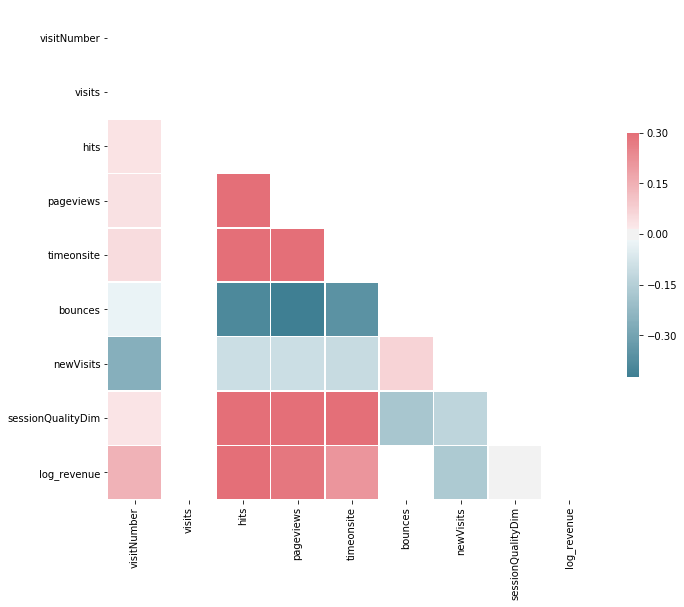

In [16]:
num_data = train_df[['visitNumber', 'visits', 'hits', 'pageviews', 'timeonsite',
       'bounces', 'newVisits', 'sessionQualityDim','log_revenue']]
corr = num_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the below analysis, we can see that out of all the distinct users that visited the page, only 1.21% actually made a purchase contributing to the revenue.


In [17]:
groupby_user_revenue[groupby_user_revenue['totalTransactionRevenue'] > 0].shape[0]/groupby_user_revenue.shape[0]


0.012196696143665085

From the below analysis, we can see that out of all the visits to the page, only 1% actually made a purchase contributing to the revenue.
This is far less than the first assumption made of the split being 80:20.

In [18]:
train_df[train_df['totalTransactionRevenue'].notnull()].shape[0]/train_df.shape[0]

0.010857976792681972

The below plot shows that 'log_revenue' follows a normal distribution.

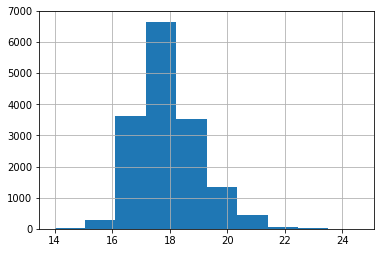

In [19]:
train_df['log_revenue'].hist()

In [20]:
revenue_transactions = train_df[train_df['totalTransactionRevenue'].notnull()]
nonrevenue_transactions = train_df[train_df['totalTransactionRevenue'].isnull()]
print('size of no null ' + str(revenue_transactions.shape[0]))
print('size of with null ' + str(nonrevenue_transactions.shape[0]))

size of no null 15959
size of with null 1453836


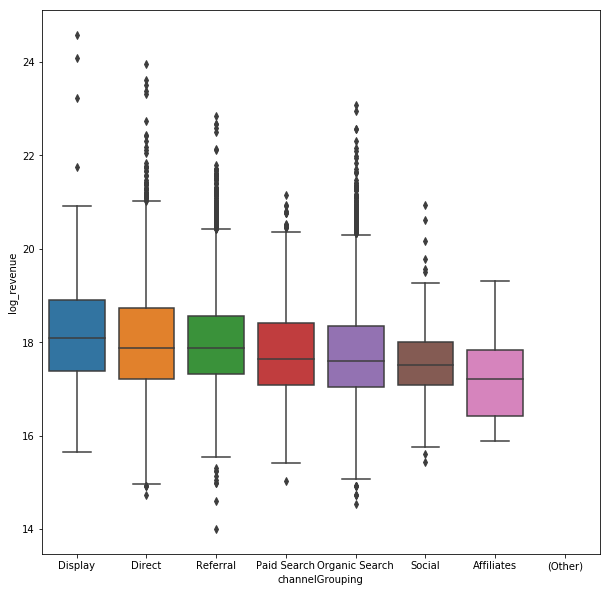

In [21]:
l = list(train_df.groupby(by = 'channelGrouping')['log_revenue'].mean().reset_index().sort_values(by = ['log_revenue'], ascending=False)['channelGrouping'])
plt.figure(figsize=(10,10))
ax = sns.boxplot(x = 'channelGrouping', y = 'log_revenue', data = train_df, order=l)

It can be seen that, among all the browsers, firefox on an average contributes more to the revenue followed by Chrome. 

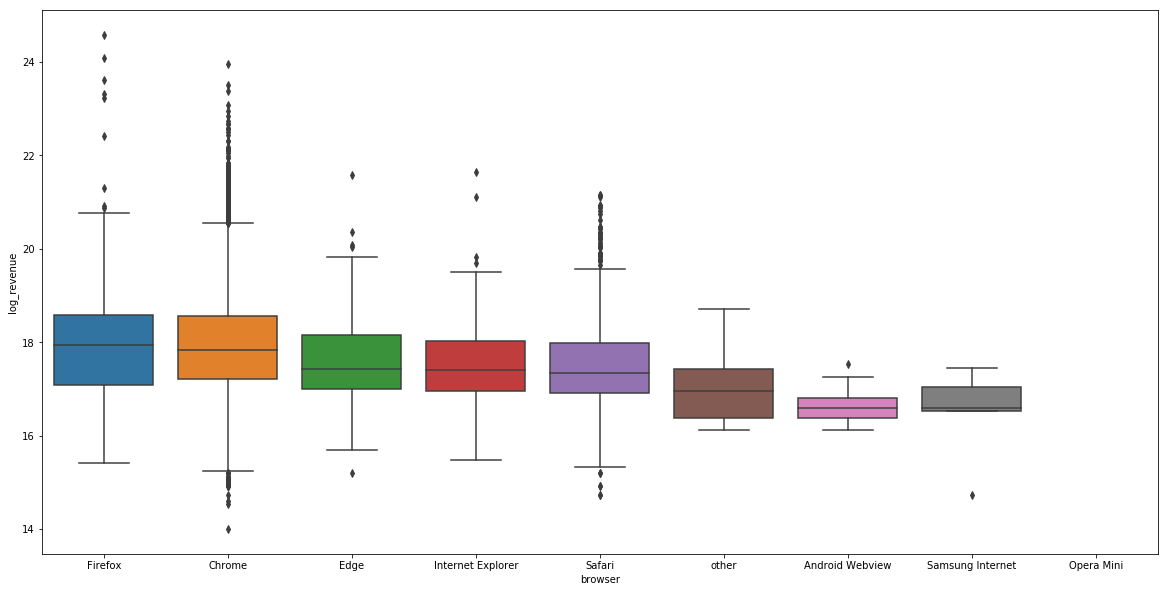

In [22]:
l = list(train_df.groupby(by = 'browser')['log_revenue'].mean().reset_index().sort_values(by = ['log_revenue'], ascending=False)['browser'])
plt.figure(figsize=(20,10))
ax = sns.boxplot(x = 'browser', y = 'log_revenue', data = revenue_transactions, order=l)

The Operating System that contributes more to the revenue per visit is Chrome OS followed by Macintosh.

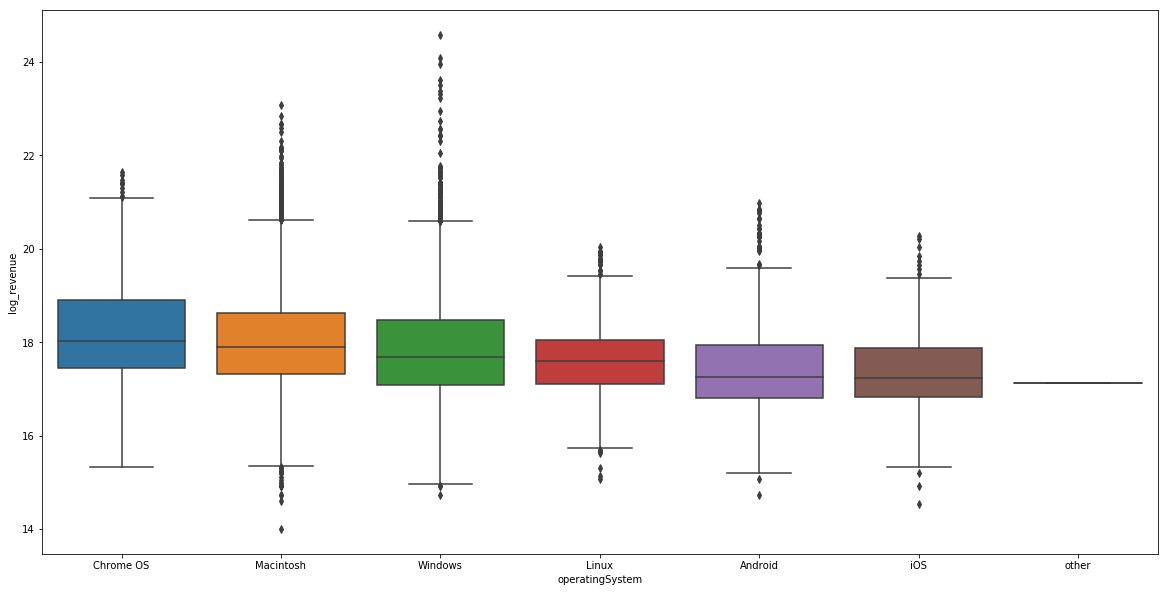

In [23]:
l = list(train_df.groupby(by = 'operatingSystem')['log_revenue'].mean().reset_index().sort_values(by = ['log_revenue'], ascending=False)['operatingSystem'])
plt.figure(figsize=(20,10))
ax = sns.boxplot(x = 'operatingSystem', y = 'log_revenue', data = train_df, order=l)

Its noticed that most of the visits are from Desktop users than tablets or mobiles.
The Device category that contributes more to the revenue per visit is desktop  followed by tablet.

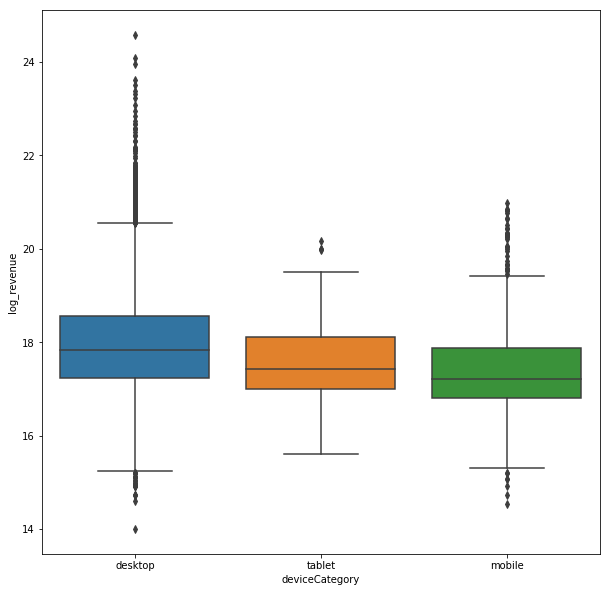

In [24]:
l = list(train_df.groupby(by = 'deviceCategory')['log_revenue'].mean().reset_index().sort_values(by = ['log_revenue'], ascending=False)['deviceCategory'])
plt.figure(figsize=(10,10))
ax = sns.boxplot(x = 'deviceCategory', y = 'log_revenue', data = train_df, order=l)

The Continent that contributes more to the revenue per visit is Africe followed by Oceania.

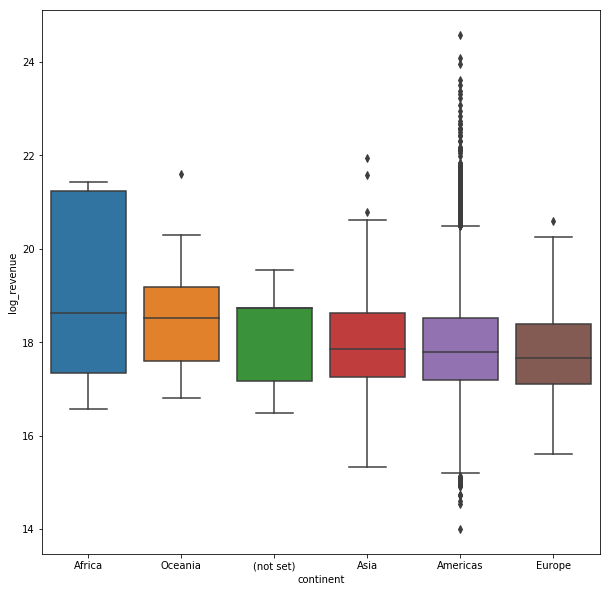

In [25]:
l = list(train_df.groupby(by = 'continent')['log_revenue'].mean().reset_index().sort_values(by = ['log_revenue'], ascending=False)['continent'])
plt.figure(figsize=(10,10))
ax = sns.boxplot(x = 'continent', y = 'log_revenue', data = train_df, order=l)

A visit to a page is considered a bounce only if the visitor leaves directly from the entrance page, without viewing any other pages.

In [26]:
def bounce_rate(col, x_size=10, y_size=10):
    groupby = train_df.groupby(by = col)['bounces'].sum().reset_index()
    groupby['count'] = train_df.groupby(by=col)[col].count().reset_index(drop=True)
    groupby['precent_bounce'] = groupby['bounces']/groupby['count']
    plt.figure(figsize=(x_size,y_size))
    l = list(groupby.sort_values(by = ['precent_bounce'], ascending=False)[col])
    ax = sns.barplot(x = col, y = 'precent_bounce', data=groupby, order=l)

From the bar graph, it is seen that the bounce rate is high for vistors from Europe. Where as visitors from America, does not bounce as frequently as others.

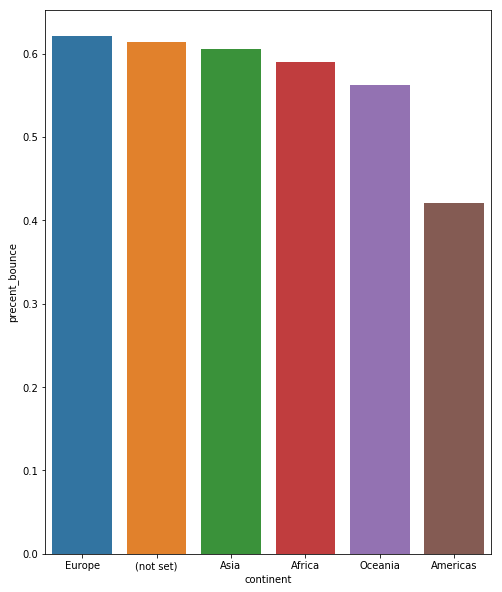

In [27]:
bounce_rate('continent', 8)

From the bar graph, it is seen that the bounce rate is high for vistors using Samsung Internet. Where as visitors using Chrome, does not bounce as frequently as others.
This could be because of the disablity of blocking pop ups in Samsung.

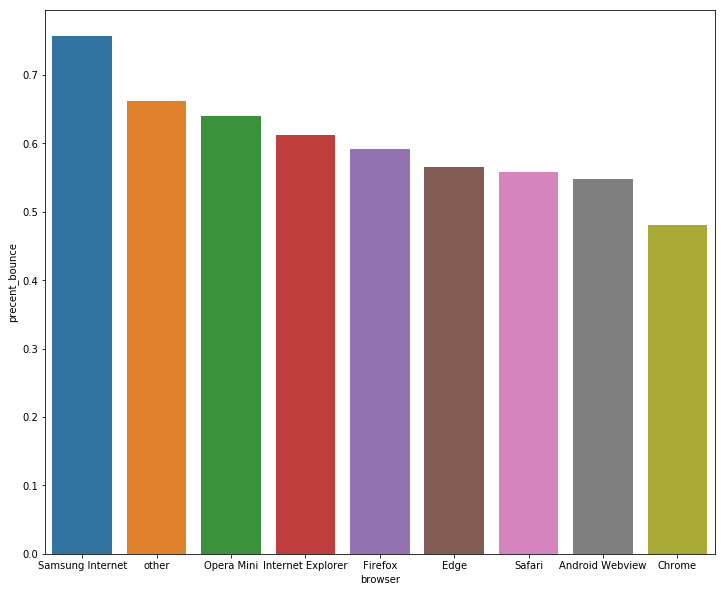

In [28]:
bounce_rate('browser', 12)

The below analysis shows that vistors having referrals are bouncing the least.

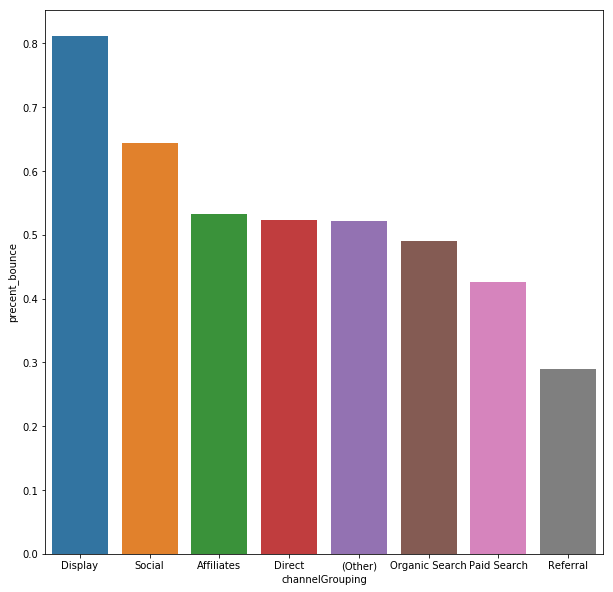

In [29]:
bounce_rate('channelGrouping')

The below analysis shows that vistors using Chrome OS are bouncing the least.

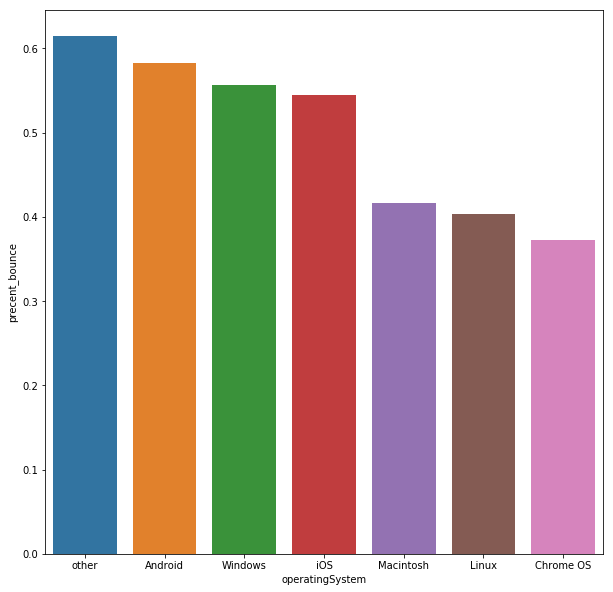

In [30]:
bounce_rate('operatingSystem')

The time series shows that the revenue is mostly flat from 2016 to 2018. But, there is a sharp increase on April 2018.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



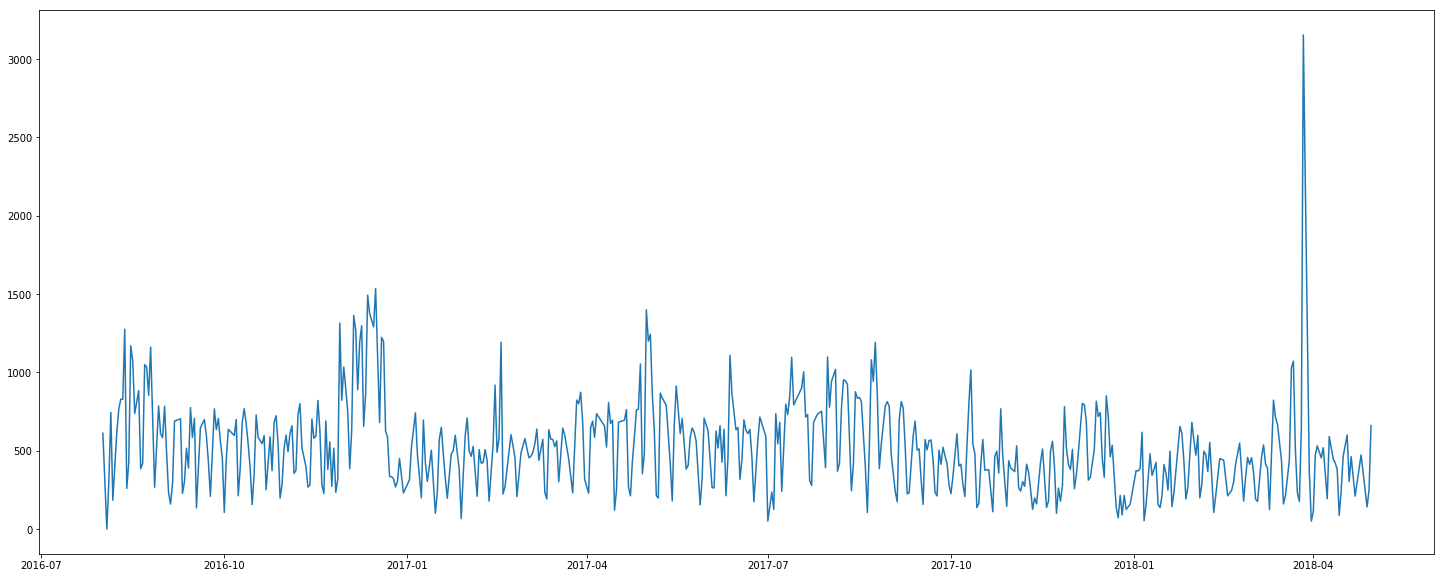

In [31]:
train_df['date'] = pd.to_datetime(train_df['date'])
group_date_revenue = train_df.groupby(by = ['date'])['log_revenue'].sum(axis=1).reset_index()
plt.figure(figsize=(25,10))
plt.plot(group_date_revenue['date'], group_date_revenue['log_revenue'])
ax.xaxis.set_major_locator(mdates.MonthLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

In [32]:
nonrevenue_transactions['log_revenue'] = nonrevenue_transactions['log_revenue'].fillna(-1)
#Filling all the NaN values with -1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
def transactions_v_nontransactions(col, s = (15,10)):
    a = revenue_transactions.groupby(by = [col])['log_revenue'].count().reset_index()
    a['log_revenue'] = a['log_revenue']/a['log_revenue'].sum()
    b = nonrevenue_transactions.groupby(by = [col])['log_revenue'].count().reset_index()
    b['log_revenue'] = b['log_revenue']/b['log_revenue'].sum()
    all_rev = a.copy()
    all_rev['non_rev'] = b['log_revenue']
    all_rev['ratio'] = all_rev['log_revenue']/all_rev['non_rev']
    plt.figure(figsize=s)
    plt.subplot(121)
    plt.barh(a[col], a['log_revenue'])
    plt.title('percentage of rows  from '+ str(col) + ' Revenue')
    plt.subplot(122)
    plt.barh(b[col], b['log_revenue'])
    plt.title('percentage of rows  from '+ str(col) + 'Non Revenue')
#     plt.subplot(212)
#     plt.barh(all_rev[col], all_rev['ratio'])
    plt.show()

The desktop users are contributing more to the revenue than mobile and tablet.

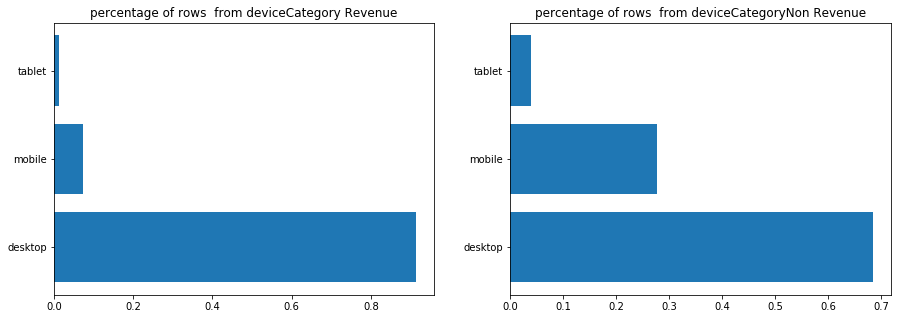

In [34]:
transactions_v_nontransactions('deviceCategory',s =(15, 5))

The visitors from America  are contributing more to the revenue and vistors from Asia, Europe are least in contributing to the revenue.

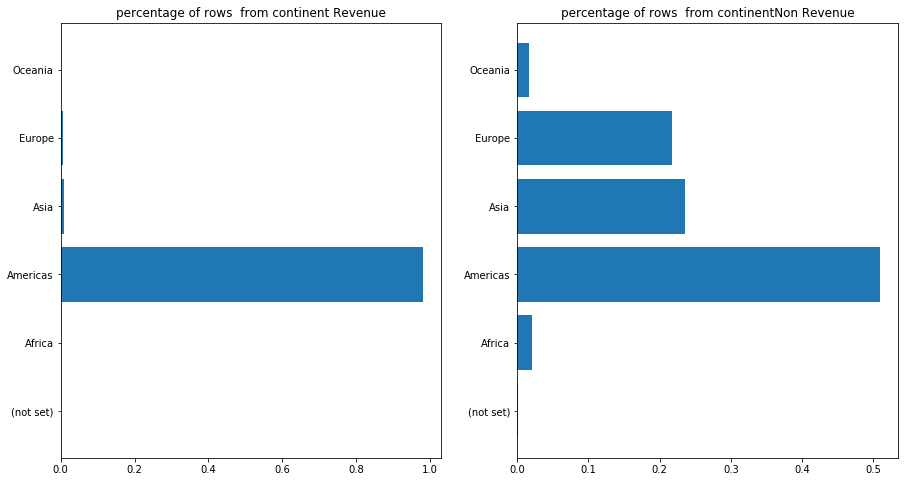

In [35]:
transactions_v_nontransactions('continent', s = (15,8))

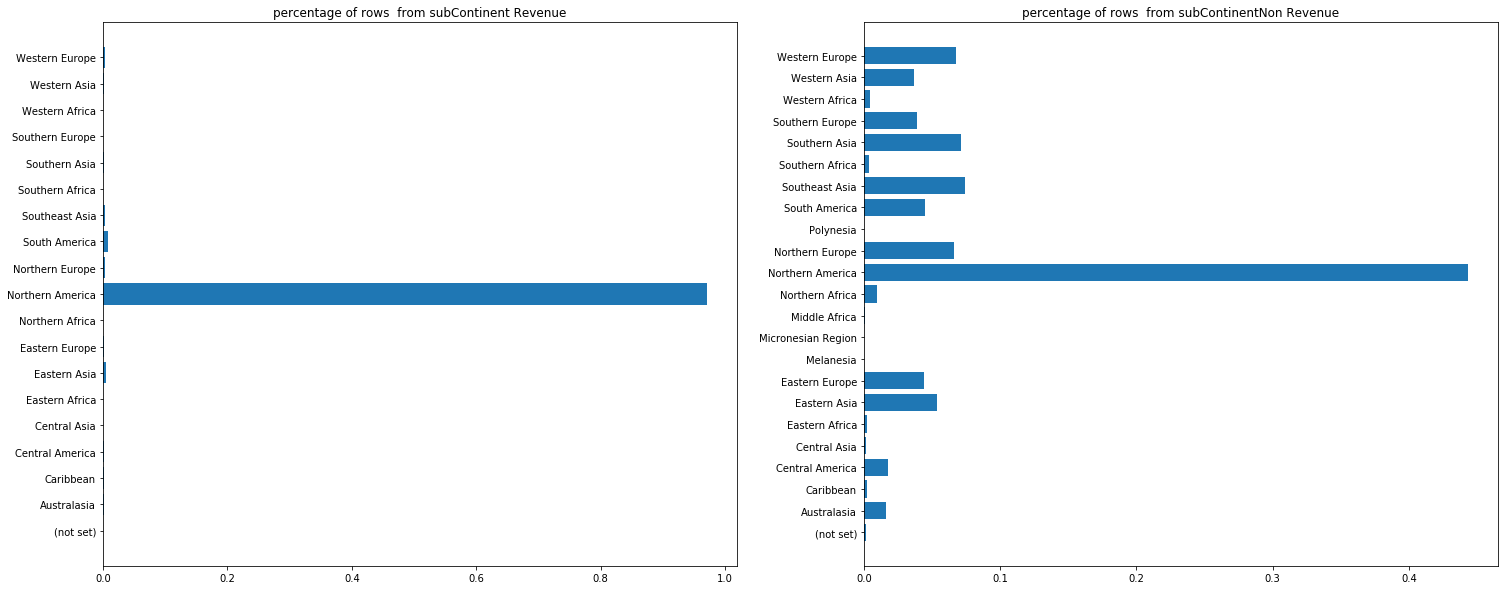

In [36]:
transactions_v_nontransactions('subContinent', s = (25, 10))

Most of the revenue is generated by the visits from chrome, Users visiting on Safari are mostly just visting the site without buying.

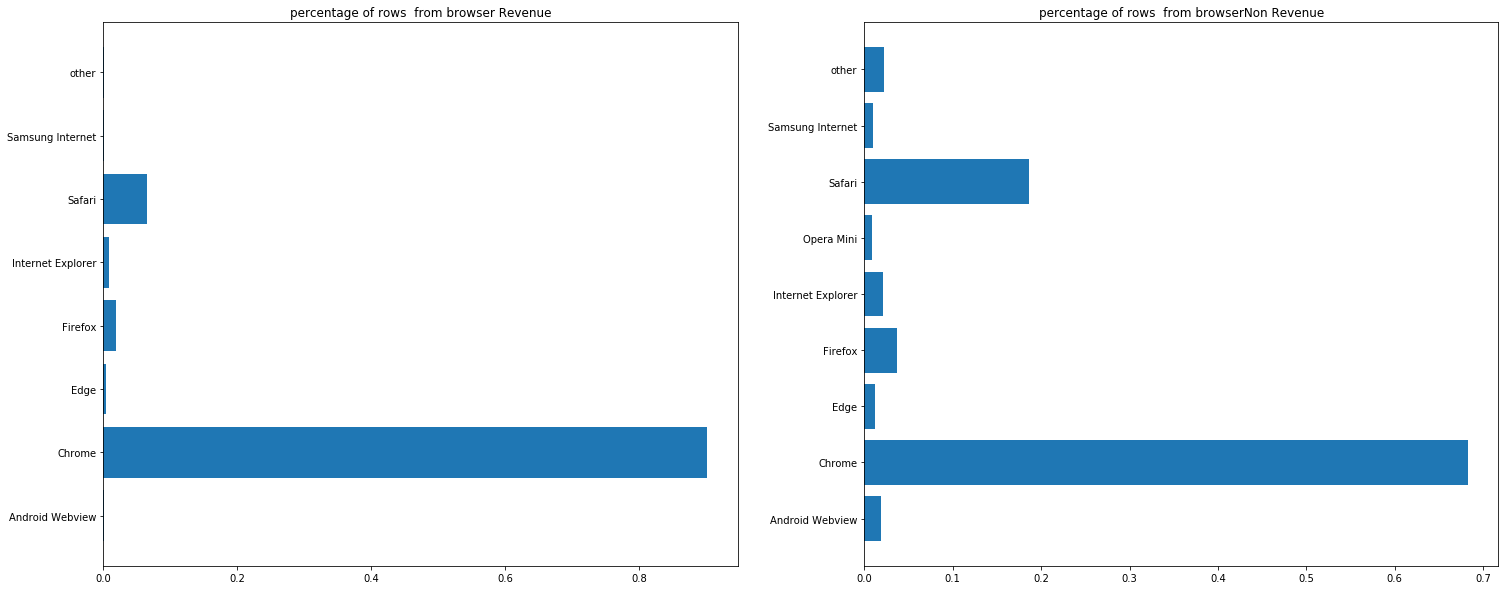

In [37]:
transactions_v_nontransactions('browser', s=(25,10))

Users using Macintosh are most probable to buy than the users using other operating systems and Visits from windows mostly won't contribute anything to the revenue 

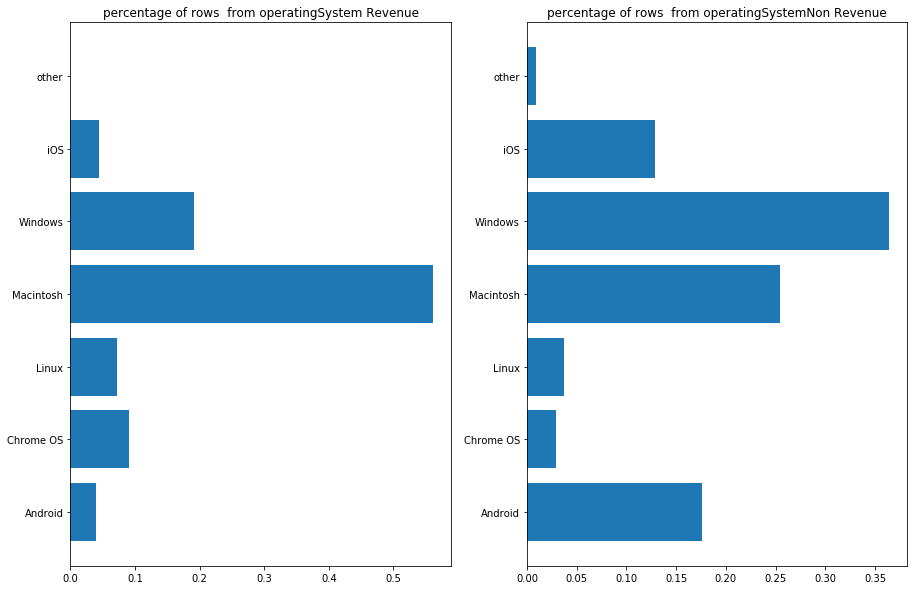

In [38]:
transactions_v_nontransactions('operatingSystem')

Visits coming from Youtube and google are mostly not useful for the retailer, while users coming directly to the site are most probable to buy something.

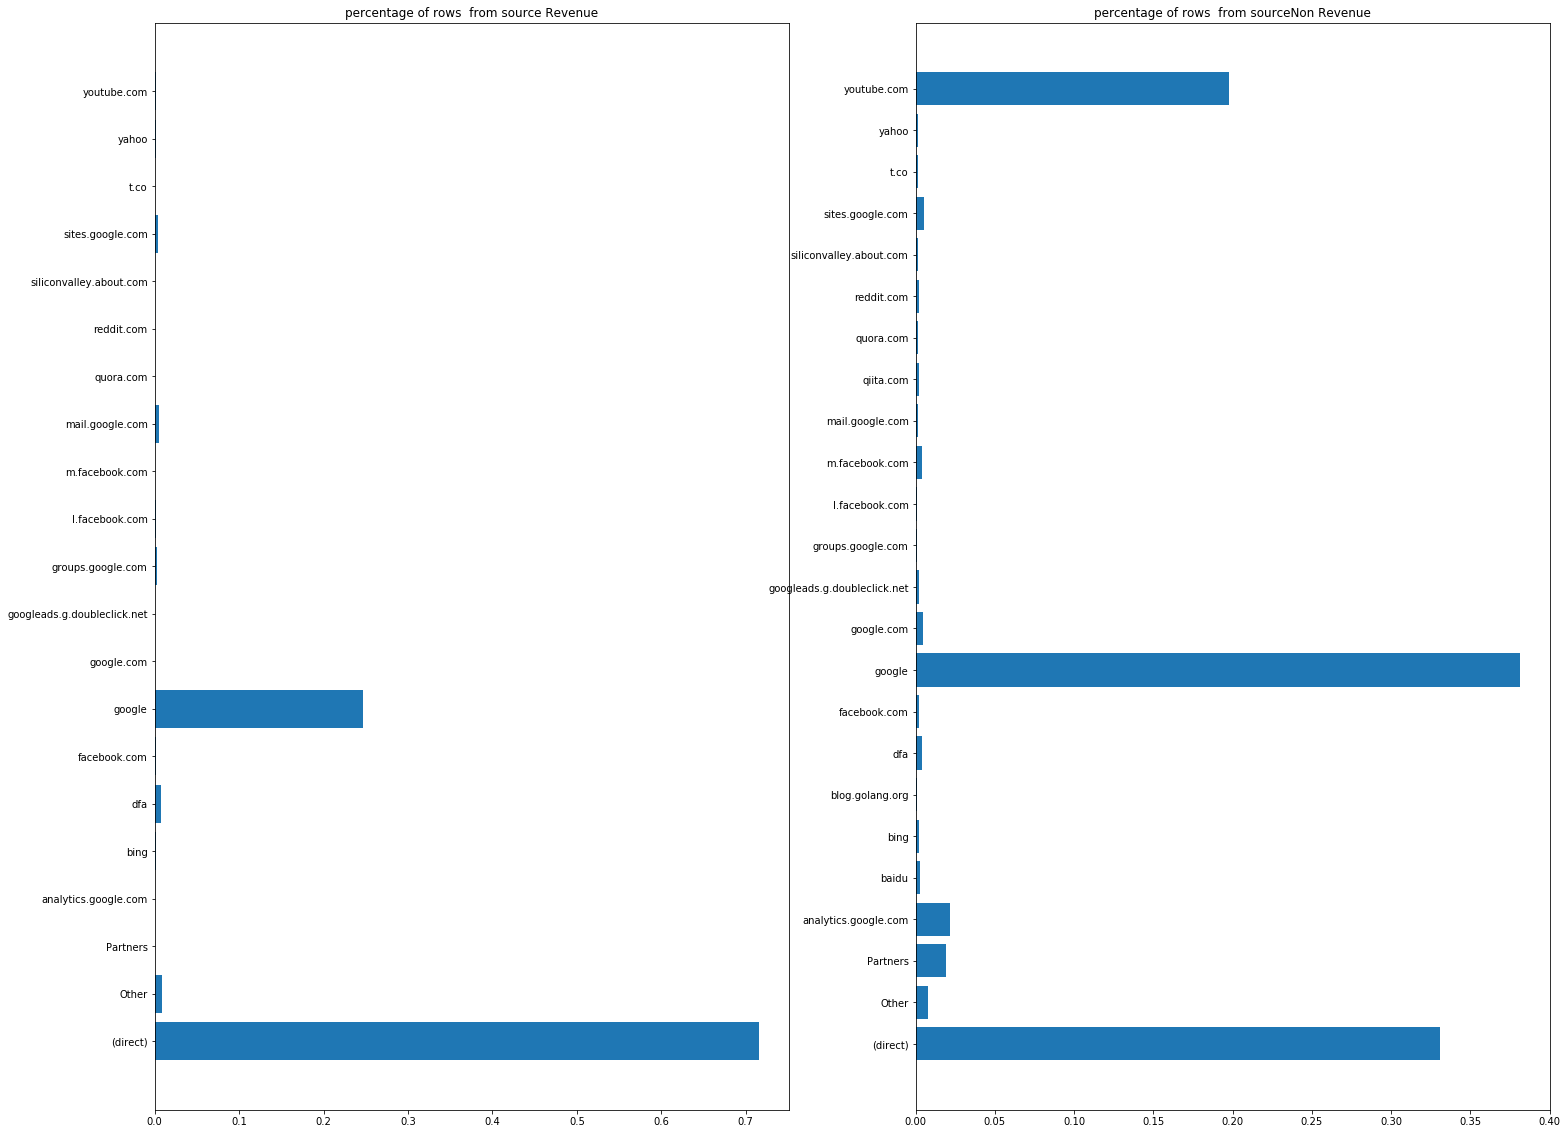

In [39]:
transactions_v_nontransactions('source', s = (25, 20))

In [40]:
#df_country_codes.drop(columns=['GDP (BILLIONS)'], inplace=True)
df_country_codes = df_country_codes.set_index('COUNTRY').to_dict()['CODE']

In [41]:
revenue_transactions['code'] = revenue_transactions['country'].apply(lambda x: df_country_codes[x] if x in list(df_country_codes.keys()) else 'USA')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The plot shows that on an average America spends about $16.6, whereas India spends about $19 and Canada spends abput $20.6

In [42]:

# fig = go.Figure(data=go.Choropleth(
#     locations = revenue_transactions['code'],
#     z = revenue_transactions['log_revenue'],
#     text = revenue_transactions['country'],
#     colorscale = 'Blues',
#     autocolorscale=False,
#     reversescale=True,
#     marker_line_color='darkgray',
#     marker_line_width=0.5,
#     colorbar_tickprefix = '$',
#     colorbar_title = 'transactions in US$',
# ))

# fig.update_layout(
#     title_text='Google Swag Transactions',
#     geo=dict(
#         showframe=False,
#         showcoastlines=False,
#         projection_type='equirectangular'
#     ),
#     annotations = [dict(
#         x=0.55,
#         y=0.1,
#         xref='paper',
#         yref='paper',
#         text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
#             CIA World Factbook</a>',
#         showarrow = False
#     )]
# )

# fig.show()

In [43]:
group_revenue = revenue_transactions.groupby(by=['code'])['log_revenue'].sum().reset_index()
group_count = revenue_transactions.groupby(by = ['code'])['log_revenue'].count().reset_index()

The total revenue is highest for America, having about 273.3kUSD, revenue generated from Canada is around 4.7kUSD and total revenue from india is measley 217USD.

In [44]:
# fig = go.Figure(data=go.Choropleth(
#     locations = group_revenue['code'],
#     z = group_revenue['log_revenue'],
#     text = group_revenue['code'],
#     colorscale = 'Blues',
#     autocolorscale=False,
#     reversescale=True,
#     marker_line_color='darkgray',
#     marker_line_width=0.5,
#     colorbar_tickprefix = '$',
#     colorbar_title = 'transactions in US$',
# ))

# fig.update_layout(
#     title_text='Google Swag Transactions revenue per country',
#     geo=dict(
#         showframe=False,
#         showcoastlines=False,
#         projection_type='equirectangular'
#     ),
#     annotations = [dict(
#         x=0.55,
#         y=0.1,
#         xref='paper',
#         yref='paper',
#         text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
#             CIA World Factbook</a>',
#         showarrow = False
#     )]
# )

# fig.show()

Most Number of visits that generated are from America around 15.2K, 267 visits from Canada and 14 Visits are from India.

In [45]:
# fig = go.Figure(data=go.Choropleth(
#     locations = group_count['code'],
#     z = group_count['log_revenue'],
#     text = group_count['code'],
#     colorscale = 'Blues',
#     autocolorscale=False,
#     reversescale=True,
#     marker_line_color='darkgray',
#     marker_line_width=0.5,
#     colorbar_tickprefix = '$',
#     colorbar_title = 'transactions',
# ))

# fig.update_layout(
#     title_text='Google Swag Transactions per country',
#     geo=dict(
#         showframe=False,
#         showcoastlines=False,
#         projection_type='equirectangular'
#     ),
#     annotations = [dict(
#         x=0.55,
#         y=0.1,
#         xref='paper',
#         yref='paper',
#         text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
#             CIA World Factbook</a>',
#         showarrow = False
#     )]
# )

# fig.show()

In [46]:
Y = train_df['log_revenue'].fillna(0)
data_x = train_df[['channelGrouping', 'visitNumber', 'browser', 'operatingSystem', 'deviceCategory',
       'continent', 'subContinent', 'source', 'medium', 'hits', 'pageviews',
       'timeonsite', 'bounces', 'newVisits', 'sessionQualityDim']]
train_x, test_x, train_y, test_y = model_selection.train_test_split(data_x, Y, test_size=0.3, random_state=42)

In [47]:
num_columns = train_x._get_numeric_data().columns
categorical_columns = [x  for x in train_x.columns if x not in num_columns]

In [48]:
num_data = train_x[num_columns]
categorical_data = train_x[categorical_columns]

In [49]:
numdata_valid = test_x[num_columns]
cat_valid = test_x[categorical_columns]

In [50]:
## random forest, Decision Trees, XgBoost, KNN can deal with missing values

In [51]:
for col in categorical_columns:
    categorical_data[col], indexes = pd.factorize(categorical_data[col])
    cat_valid[col] = indexes.get_indexer(cat_valid[col])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
train_data = pd.concat([num_data, categorical_data], axis=1)
valid_data = pd.concat([numdata_valid, cat_valid], axis=1)

In [53]:
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, categorical_feature=categorical_columns)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y

# Training the model #
model, pred_val = run_lgb(train_data, train_y, valid_data, test_y)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['browser', 'channelGrouping', 'continent', 'deviceCategory', 'medium', 'operatingSystem', 'source', 'subContinent']

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.53328
[200]	valid_0's rmse: 1.53151
[300]	valid_0's rmse: 1.53042
Early stopping, best iteration is:
[297]	valid_0's rmse: 1.53035


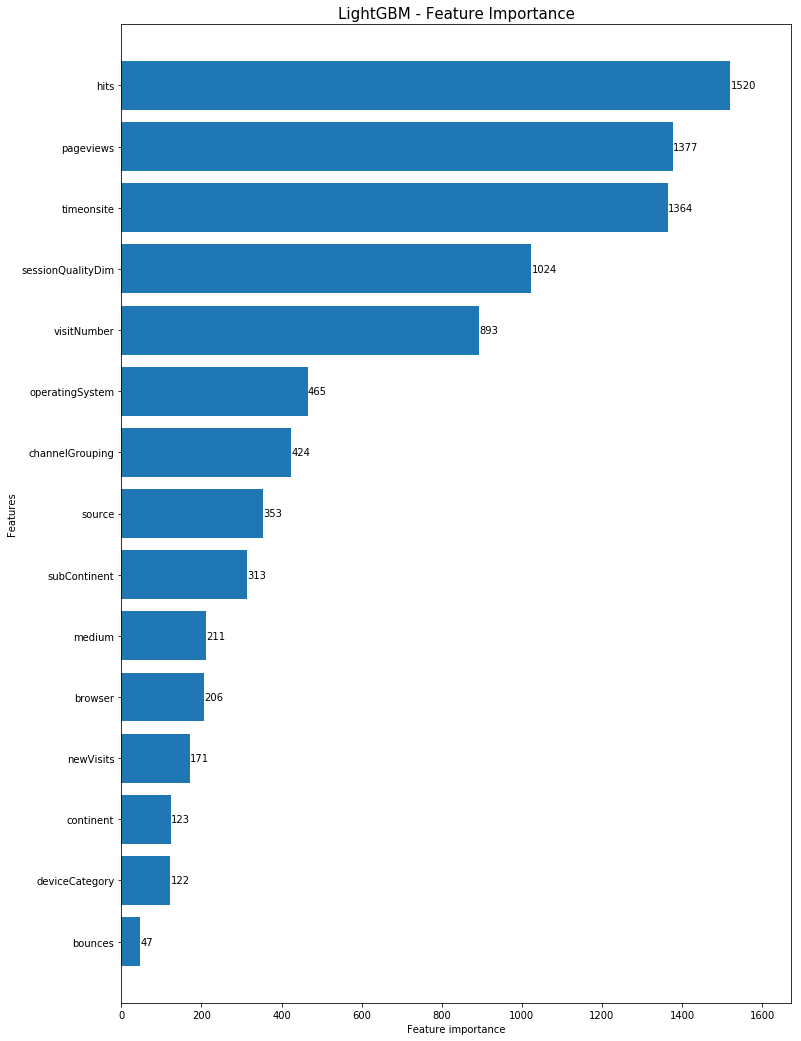

In [54]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [55]:
## Rmse value on validation data using Lightgbm model is 1.53 which is the lowest of all the other models. 
## According to lightgbm the most important features are in the following order of Hits, Pageviews, timeonsite,Sessionquality, visitnumber.

In [56]:
cat_df = train_x[categorical_columns]
train_dummies = pd.get_dummies(cat_df)
test_dummies = pd.get_dummies(test_x[categorical_columns])

In [57]:
train_dum = pd.concat([num_data, train_dummies], axis=1)
valid_dum = pd.concat([numdata_valid, test_dummies], axis=1)

In [58]:
model_xgb = XGBRegressor()
model_xgb.fit(train_dum, train_y)
pred_test = model_xgb.predict(valid_dum)
math.sqrt(metrics.mean_squared_error(pred_test, test_y))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[18:23:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


1.5538097274632625

In [59]:
lr_features = pd.DataFrame(model_xgb.feature_importances_, train_dum.columns).reset_index()
lr_features.columns = ['features', 'coefficients']
lr_features.sort_values(by = ['coefficients'], ascending=False)

,features,coefficients
52,subContinent_Northern America,0.205747
2,pageviews,0.188478
13,channelGrouping_Referral,0.100436
31,deviceCategory_desktop,0.070005
6,sessionQualityDim,0.068115
...,...,...
51,subContinent_Northern Africa,0.000000
53,subContinent_Northern Europe,0.000000
54,subContinent_Polynesia,0.000000
19,browser_Internet Explorer,0.000000


In [60]:
## Rmse on validation data for Xgboost is 1.55 and Subcontinent_America is the most important feature in predicting the response variable followed by pageviews, channelgrouping_referral

In [61]:
import statsmodels.api as sm
from scipy import stats

In [62]:
X2 = sm.add_constant(train_dum)
est = sm.OLS(train_y, X2)
est2 = est.fit()
print(est2.summary())

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     3080.
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:28:48   Log-Likelihood:            -1.9937e+06
No. Observations:             1028856   AIC:                         3.987e+06
Df Residuals:                 1028775   BIC:                         3.988e+06
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [63]:
## R squared value of the linear regression model is very low at (0.193) and there is no one major feature that contributes more to the response variable.

In [64]:
model = linear_model.LinearRegression()
reg = model.fit(train_dum, train_y)
pred_test_l = model.predict(valid_dum)
math.sqrt(metrics.mean_squared_error(pred_test_l, test_y))

1.6642432298362866

In [65]:
## Rmse value on the validation data for the linear regression model is 1.66

In [66]:
lr_features = pd.DataFrame(reg.coef_, train_dum.columns).reset_index()
lr_features.columns = ['features', 'coefficients']
lr_features.sort_values(by = ['coefficients'], ascending=False)

,features,coefficients
87,medium_(none),0.633969
14,channelGrouping_Social,0.389022
65,source_Partners,0.340329
4,bounces,0.337295
78,source_mail.google.com,0.287508
...,...,...
8,channelGrouping_Affiliates,-0.198437
89,medium_affiliate,-0.198437
7,channelGrouping_(Other),-0.226737
93,medium_referral,-0.347671


In [67]:
model = Sequential()
model.add(Dense(500, input_dim=train_dum.shape[1], activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1))

In [68]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model.fit(train_dum, train_y, validation_split=0.3, epochs=8, batch_size=128)

Train on 720199 samples, validate on 308657 samples
Epoch 1/8
720199/720199 [==============================] - 34s 47us/step - loss: 3.5054 - mean_squared_error: 3.5054 - val_loss: 2.6742 - val_mean_squared_error: 2.6742
Epoch 2/8
720199/720199 [==============================] - 33s 46us/step - loss: 2.8437 - mean_squared_error: 2.8437 - val_loss: 2.6457 - val_mean_squared_error: 2.6457
Epoch 3/8
720199/720199 [==============================] - 33s 46us/step - loss: 2.7492 - mean_squared_error: 2.7492 - val_loss: 2.6136 - val_mean_squared_error: 2.6136
Epoch 4/8
720199/720199 [==============================] - 32s 44us/step - loss: 2.6874 - mean_squared_error: 2.6874 - val_loss: 2.5683 - val_mean_squared_error: 2.5683
Epoch 5/8
720199/720199 [==============================] - 33s 46us/step - loss: 2.6313 - mean_squared_error: 2.6313 - val_loss: 2.5179 - val_mean_squared_error: 2.5179
Epoch 6/8
720199/720199 [==============================] - 31s 44us/step - loss: 2.6196 - mean_squared_

In [69]:
pred_nn = model.predict(valid_dum)
math.sqrt(metrics.mean_squared_error(pred_nn, test_y))

1.558130928972998

In [70]:
## Rmse of The neural network model with 3 hidden layers is 1.55